# 前言

**未處理圖片檔目錄**

    ./OLD_and_image\/Non-processed

**分割後圖片檔目錄**

    ./Nums2
    
**用於驗證模型準確度的圖片檔目錄**

    ./predict

---
---

**鑒於仿作後模型的預測能力不佳，重新製作**

    ./OLD_and_image\/辨識驗證碼.ipynb
    
    判斷出模型預測能力不佳
    
    配合request.session() 突破驗證碼，
    可見於上述[辨識驗證碼.ipynb]
    
    
**應是用於訓練的數據粗糙不佳**

    ./OLD_and_image\/模型訓練.ipynb
    
    分割(使用CV)後圖用 `plt` 儲存灰度圖 (14X24) -> (600X400)
    PIL 的 .convert('1') 轉二值化 造成圖片失去數字的樣貌
    可見於上述[模型訓練.ipynb]

**故採取**

    灰度化、 二值化、 分割(使用CV) 
    -> 固定大小(resize 採用INTER_LINEAR 雙線性插值) 
    -> 儲存(二值化經過resize，不再二值，但去除顏色影響)[灰度]
    
**=> 倒進模型訓練**
    
    經過測試(10例) 僅有一例中的9判斷為8
    修正模型，隱藏層{(30,30,30) -> (1200,600)}後測試全過
    
    


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#前言" data-toc-modified-id="前言-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>前言</a></span></li><li><span><a href="#分割圖片儲存" data-toc-modified-id="分割圖片儲存-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>分割圖片儲存</a></span><ul class="toc-item"><li><span><a href="#輸出至檔案" data-toc-modified-id="輸出至檔案-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>輸出至檔案</a></span></li></ul></li><li><span><a href="#訓練" data-toc-modified-id="訓練-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>訓練</a></span><ul class="toc-item"><li><span><a href="#網格出圖-添加標籤(人工辨識後的目錄名)-數據" data-toc-modified-id="網格出圖-添加標籤(人工辨識後的目錄名)-數據-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>網格出圖 添加標籤(人工辨識後的目錄名) 數據</a></span></li><li><span><a href="#資料前處理" data-toc-modified-id="資料前處理-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>資料前處理</a></span></li><li><span><a href="#模型設定" data-toc-modified-id="模型設定-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>模型設定</a></span></li><li><span><a href="#檢測結果" data-toc-modified-id="檢測結果-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>檢測結果</a></span></li><li><span><a href="#模型儲存(pkl)" data-toc-modified-id="模型儲存(pkl)-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>模型儲存(pkl)</a></span></li></ul></li><li><span><a href="#測試模型" data-toc-modified-id="測試模型-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>測試模型</a></span><ul class="toc-item"><li><span><a href="#模型題取" data-toc-modified-id="模型題取-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>模型題取</a></span></li><li><span><a href="#單一例測試" data-toc-modified-id="單一例測試-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>單一例測試</a></span></li><li><span><a href="#測試(從圖片檔目錄[已將正解標記在檔名])" data-toc-modified-id="測試(從圖片檔目錄[已將正解標記在檔名])-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>測試(從圖片檔目錄[已將正解標記在檔名])</a></span></li></ul></li></ul></div>

# 分割圖片儲存

In [51]:
import cv2

In [10]:

def ImgSplitSave(flie_name='kaptcha.jpg', save_name='kaptcha'):

    # 灰度化
    img = cv2.imread(flie_name,0) # 讀進來就是灰度化的數字陣列
    #imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 過濾 二值化
    # 大於10則返回255，否則 0，此數字要調適
    # 區分出數字與其他背景的區別
    # 可用 plt 查看圖，因 notebook 不支持 cv2.imshow('圖片名稱',img:圖片陣列) 
    ret, thresh = cv2.threshold(img, 10, 255, 0)

    # 團聚分割，以像素點的聚集作為依據
    # 缺點，驗證碼中的數字，若有重疊，會判斷為一塊(粗糙的做法，直接剖半)
    # contours 一連串的點，之後用到
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 依 x 排序各個團聚
    # boundingRect，界定出團聚的邊界
    # 返回 (x,y,w,h) : x,y座標點， w,h寬高
    cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in contours], key=lambda x:x[1])

    # 有時切出來的團塊並非完整數字
    # 依據 w,h 寬高 判斷
    ary = []
    for (c,_) in cnts:
        (x,y,w,h) = cv2.boundingRect(c)
        #print((x,y,w,h))
        #ary.append((x,y,w,h) )
        if w >= 10 and h >= 15 :
            ary.append((x,y,w,h) )

    # 儲存圖片 CV
    # 訓練用 固定大小 20x30
    for i, (x,y,w,h) in enumerate(ary):
        # 存二值化的圖
        roi = thresh[y:y+h, x:x+w]
        # cv無法在notebook出圖，可配合
        plt.imshow(roi)
        
        # INTER_NEAREST最近邻插值 二值化考慮
        # INTER_LINEAR 双线性插值（默认设置）
        pic = cv2.resize(roi, (20, 30), interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(f'{save_name}_{i}.jpg', pic)
        
# 測試
ImgSplitSave(flie_name='kaptcha.jpg', save_name='kaptcha')

## 輸出至檔案

In [4]:
import os

In [11]:
for root, dirs, files in os.walk('./OLD_and_image/Non-processed'):
    for name in files:
        flie_name = os.path.join(root, name)
        print(flie_name)
        save_name = './Nums2/' + name.split('.')[0]
        print(save_name)
        ImgSplitSave(flie_name=flie_name, save_name=save_name)

./OLD_and_image/Non-processed\N10.jpg
./Nums2/N10
./OLD_and_image/Non-processed\N11.jpg
./Nums2/N11
./OLD_and_image/Non-processed\N110.jpg
./Nums2/N110
./OLD_and_image/Non-processed\N111.jpg
./Nums2/N111
./OLD_and_image/Non-processed\N112.jpg
./Nums2/N112
./OLD_and_image/Non-processed\N113.jpg
./Nums2/N113
./OLD_and_image/Non-processed\N114.jpg
./Nums2/N114
./OLD_and_image/Non-processed\N115.jpg
./Nums2/N115
./OLD_and_image/Non-processed\N116.jpg
./Nums2/N116
./OLD_and_image/Non-processed\N117.jpg
./Nums2/N117
./OLD_and_image/Non-processed\N118.jpg
./Nums2/N118
./OLD_and_image/Non-processed\N119.jpg
./Nums2/N119
./OLD_and_image/Non-processed\N12.jpg
./Nums2/N12
./OLD_and_image/Non-processed\N120.jpg
./Nums2/N120
./OLD_and_image/Non-processed\N121.jpg
./Nums2/N121
./OLD_and_image/Non-processed\N122.jpg
./Nums2/N122
./OLD_and_image/Non-processed\N123.jpg
./Nums2/N123
./OLD_and_image/Non-processed\N124.jpg
./Nums2/N124
./OLD_and_image/Non-processed\N125.jpg
./Nums2/N125
./OLD_and_image/No

# 訓練

## 網格出圖 添加標籤(人工辨識後的目錄名) 數據

In [14]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'2')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'3')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'4')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'6')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'7')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'8')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

Text(0,7,'9')

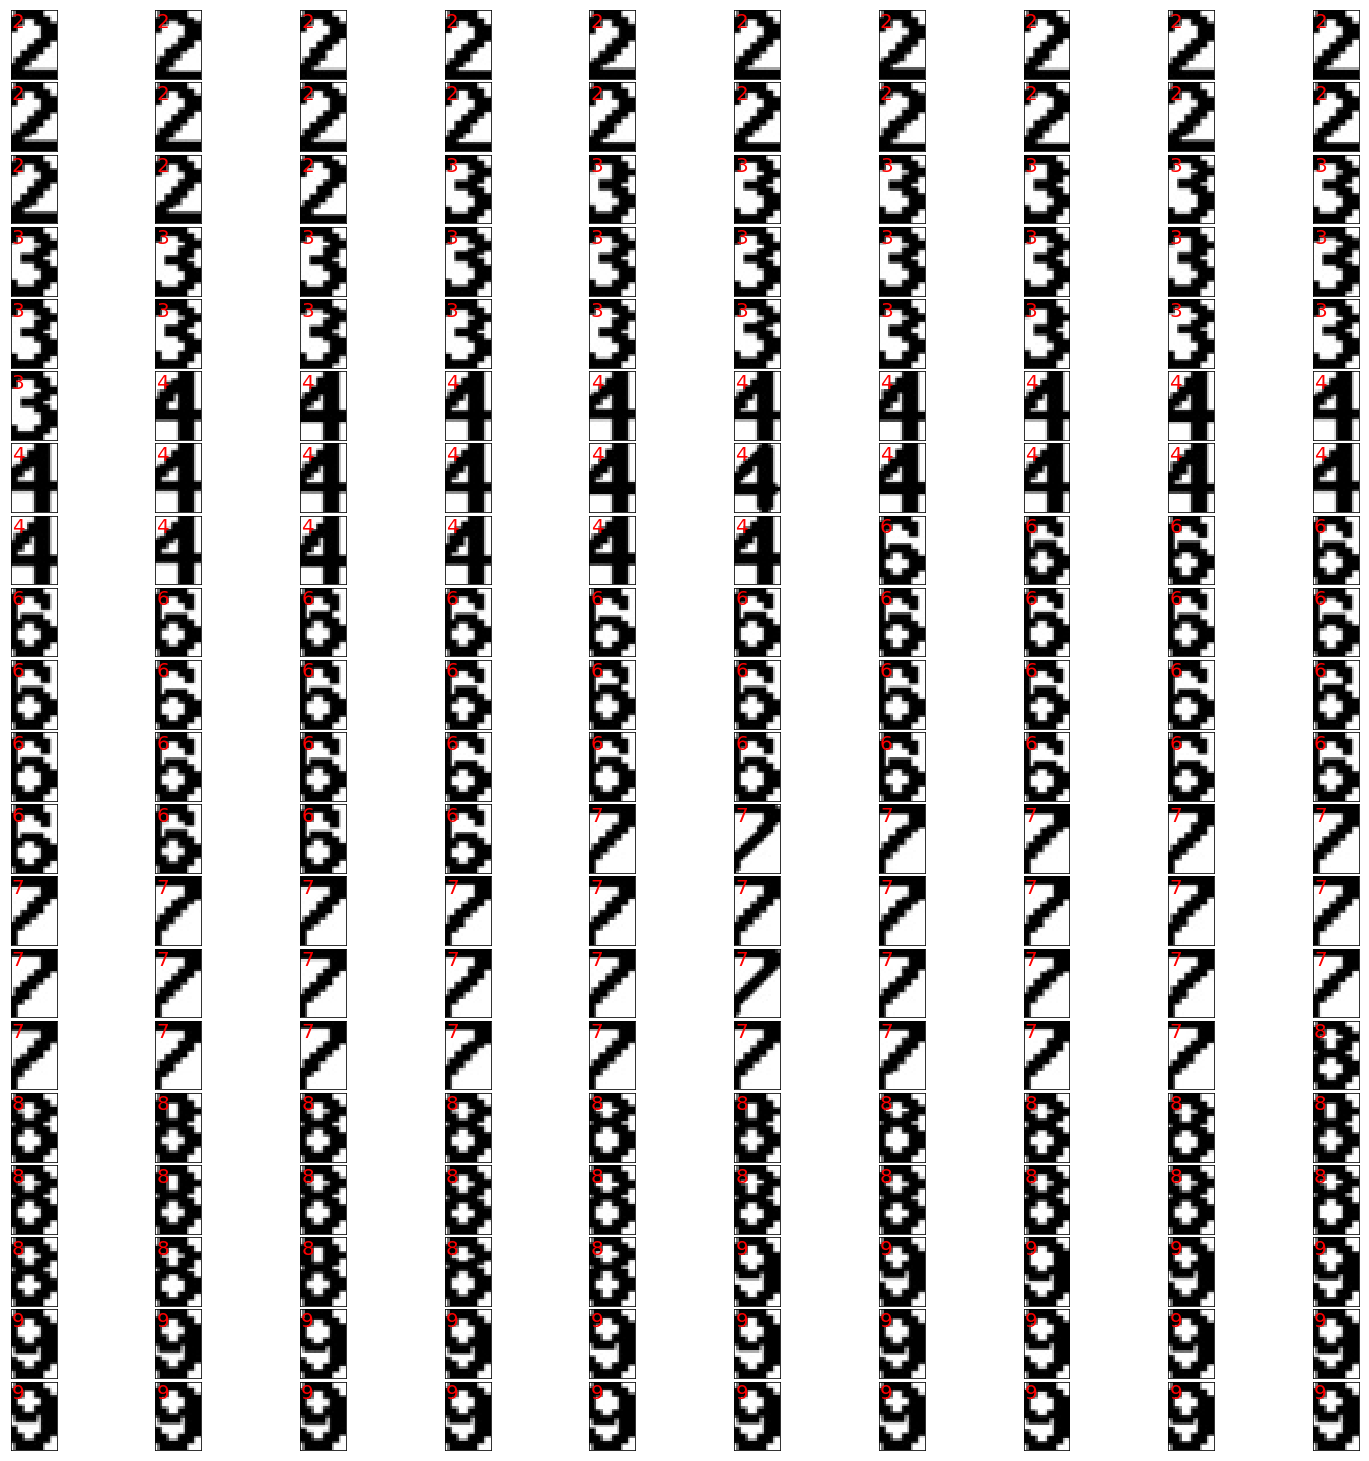

In [52]:
digits = []
labels = []

fig = plt.figure(figsize = (20,20))
cnt = 0 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in [2,3,4,6,7,8,9]:
    for img_name in os.listdir('./Nums2/{}/'.format(i)):
        
        #print(f'./Nums2/{i}/{img_name}')
        img = cv2.imread(f'./Nums2/{i}/{img_name}',0)
       
        # .flatten() array扁平化 2d[[x,y]...] -> 1d[x]
        digits.append(img.flatten())
        labels.append(i)
        
        # 網格出圖
        # xticks=[], yticks=[] 不顯示座標
        ax = fig.add_subplot(20, 10, cnt+1, xticks=[], yticks=[])
        ax.imshow(img,cmap=plt.cm.binary,interpolation='nearest')
        ax.text(0, 7, str(i), color="red", fontsize = 20)        
        cnt = cnt + 1
        
        

## 資料前處理

In [20]:
# digits:list -> np.array
# 方便查看
# 訓練用list也可
digit_ary  = np.array(digits)
digit_ary.shape
digit_ary

(200, 600)

array([[  0, 140, 255, ..., 255, 255, 255],
       [  0, 139, 254, ..., 255, 255, 255],
       [  0, 140, 255, ..., 255, 255, 255],
       ...,
       [  0, 141, 255, ...,   1,   0,   0],
       [  0, 141, 255, ...,   0,   0,   3],
       [  0, 140, 255, ...,   0,   0,   0]], dtype=uint8)

In [55]:
# 標準化
# 數值差異大(0~255)，大部分集中於 0 OR 255
# 故使用 StandardScaler()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(digit_ary)
X_scaled = scaler.transform(digit_ary)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 模型設定

In [40]:
from sklearn.neural_network import MLPClassifier
# 經過測試(10例) 僅有一例中的9判斷為8
# 修正模型，隱藏層{(30,30,30) -> (1200,600) 按照讀過的 隱藏層(第一層)為輸入的2倍較佳}
# 其他隨意測試，max_iter=3000 訓練夠多次，才能擬和數據
mlp = MLPClassifier(hidden_layer_sizes=(1200,600), activation='tanh', max_iter = 3000)
mlp.fit(X_scaled,labels)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1200, 600), learning_rate='constant',
       learning_rate_init=0.001, max_iter=3000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## 檢測結果

In [41]:
predicted = mlp.predict(X_scaled)
predicted

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9])

In [42]:
predicted == labels

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## 模型儲存(pkl)

In [43]:
from sklearn.externals import joblib

joblib.dump(mlp, 'captcha.pkl') 

joblib.dump(scaler, "scaler.pkl")

['captcha.pkl']

['scaler.pkl']

# 測試模型

## 模型題取

In [44]:
clf = joblib.load('captcha.pkl') 

scaler = joblib.load("scaler.pkl") 

## 單一例測試


In [26]:
# 分割圖片儲存
ImgSplitSave(flie_name='kaptcha.jpg', save_name='kaptcha')

StandardScaler(copy=True, with_mean=True, with_std=True)

'2882'

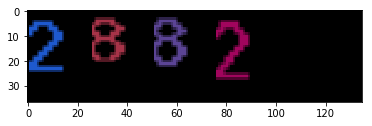

In [31]:
data = []
for i in range(4):
    # 讀灰度圖
    imgCV = cv2.imread(f'kaptcha_{i}.jpg',0)
    data.append(imgCV.flatten())
scaler.fit(data)
data_scaled = scaler.transform(data)
clf.predict(data_scaled)

''.join([str(i) for i in clf.predict(data_scaled)])

imgCV = cv2.imread(f'kaptcha.jpg')
plt.imshow(imgCV)

## 測試(從圖片檔目錄[已將正解標記在檔名])

In [56]:
# 儲存正解
ans = []
# 預測值
predictNum = []

for root, dirs, files in os.walk('./predict'):
    for name in files:
        flie_name = os.path.join(root, name)
        # print(flie_name)
        save_name = 'TEST'
        # print(save_name)
        ImgSplitSave(flie_name=flie_name, save_name=save_name)
        
        data = []
        for i in range(4):
            # 讀灰度圖
            imgCV = cv2.imread(f'{save_name}_{i}.jpg',0)
            # .flatten() 2d -> 1d
            data.append(imgCV.flatten())
        scaler.fit(data)
        data_scaled = scaler.transform(data)
        
        # 添加預測值
        predictNum.append(
            ''.join([str(i) for i in clf.predict(data_scaled)])
        )
        # 添加正解
        ans.append(name.split('.')[0])

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [57]:
# 確認結果 顯示(對錯, 正解)
[(True,ans[i]) if ans[i] == predictNum[i] else (False,ans[i]) for i in range(10)]

[(True, '2882'),
 (True, '4377'),
 (True, '4863'),
 (True, '6387'),
 (True, '6764'),
 (True, '7864'),
 (True, '7997'),
 (True, '8284'),
 (True, '8683'),
 (True, '9449')]